In [1]:
!pip install gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 6.7 MB/s eta 0:00:00


In [2]:
!pip install gymnasium[atari]
!pip install autorom[accept-rom-license]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 4.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446659 sha256=74ac8caddf30d3796d0342a5cb3f07f4dbc086fa3a627347711386c1026c8d30
  Stored in directory: /root/.cache/pip/wheels/6b/1b/ef/a43ff1a2f1736d5711faa1ba4c1f61be1131b8899e6a057811
Successfully built AutoROM.accept-rom-license


In [3]:
import gymnasium as gym
import numpy as np
import random
import cv2
from matplotlib import pyplot as plt
from IPython.display import clear_output
from gym.wrappers import RecordEpisodeStatistics,AtariPreprocessing
import tensorflow as tf
from tensorflow import keras
from keras import models,layers
from collections import deque

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1/1 [==============================] - 0s 166ms/step
0


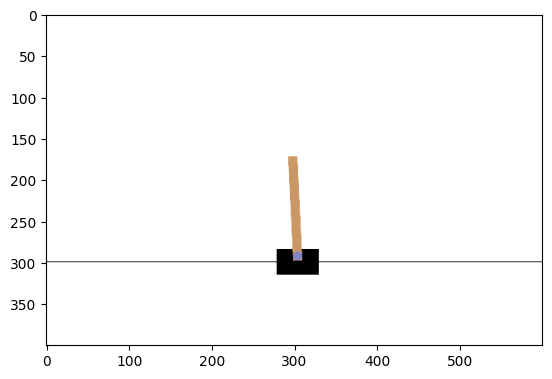

1/1 [==============================] - 0s 24ms/step
0


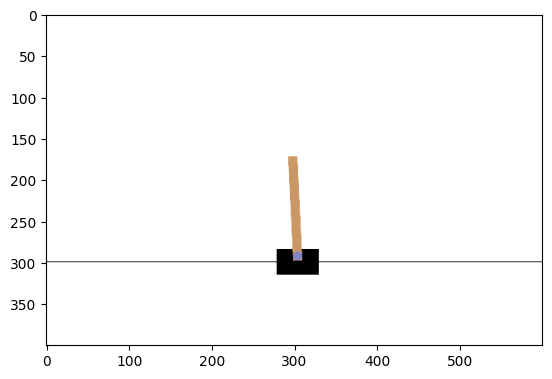

1/1 [==============================] - 0s 24ms/step
0


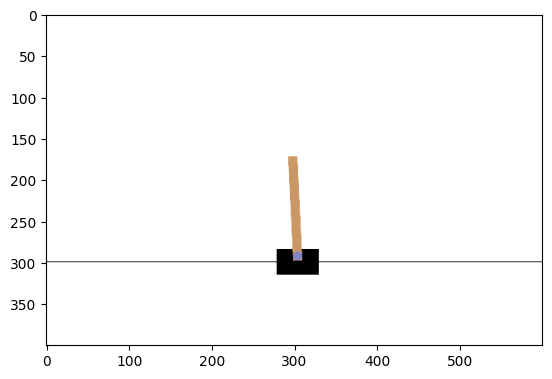

1/1 [==============================] - 0s 42ms/step
0


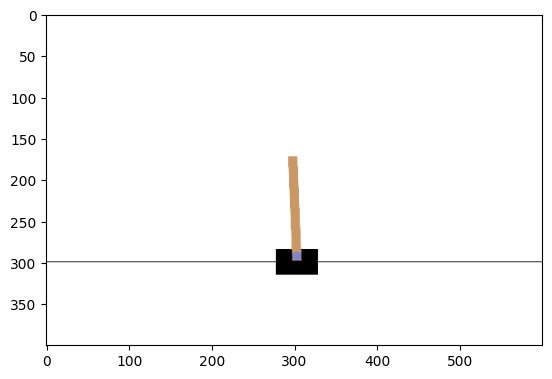

1/1 [==============================] - 0s 24ms/step
0


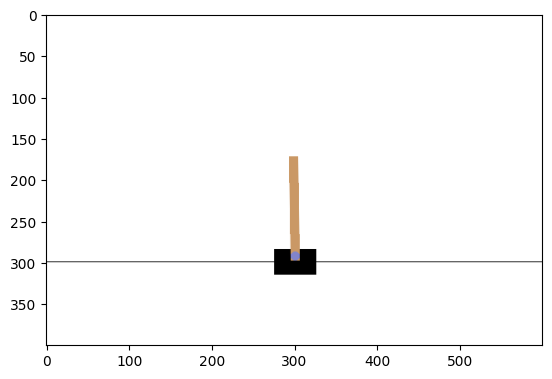

1/1 [==============================] - 0s 22ms/step
0


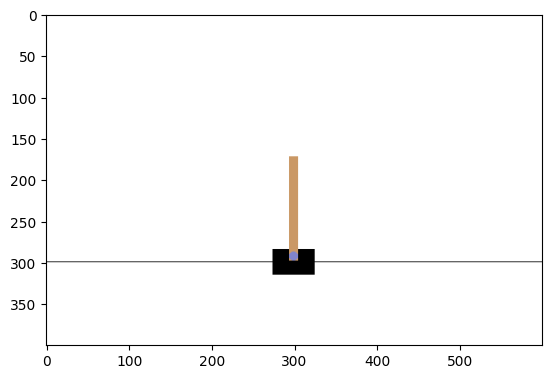

1/1 [==============================] - 0s 23ms/step
0


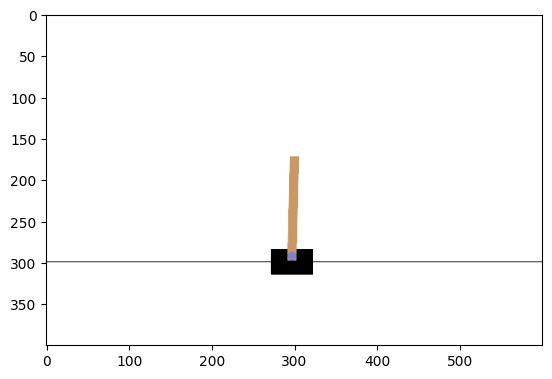

1/1 [==============================] - 0s 25ms/step
0


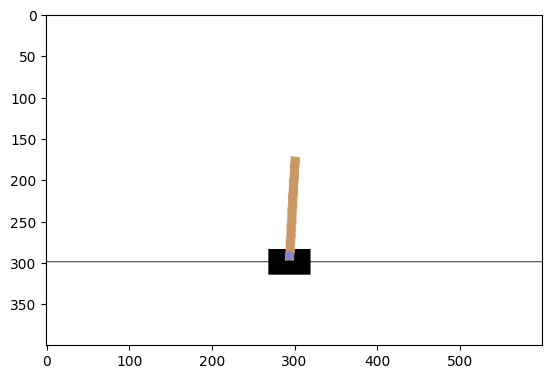

1/1 [==============================] - 0s 45ms/step
0


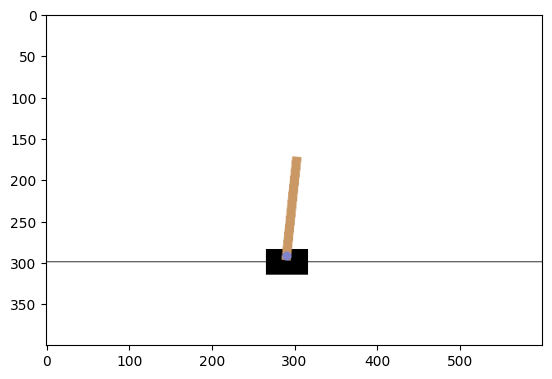

1/1 [==============================] - 0s 76ms/step
0


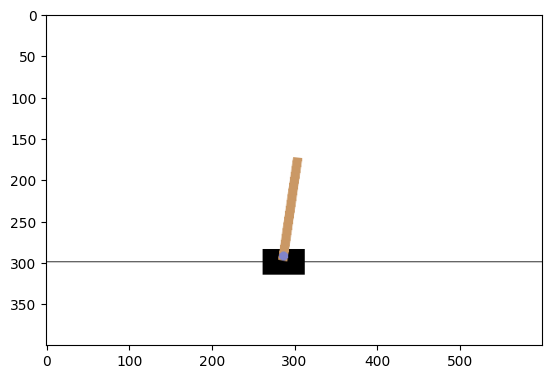

1/1 [==============================] - 0s 117ms/step
0


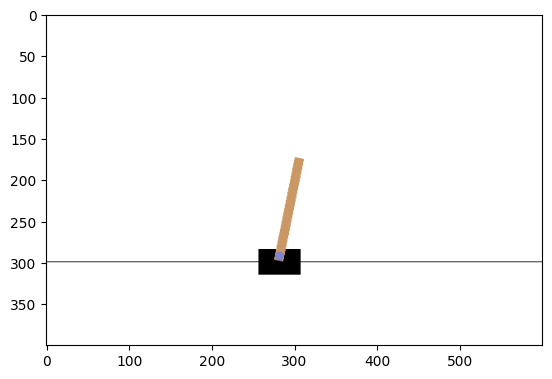

1/1 [==============================] - 0s 55ms/step
0


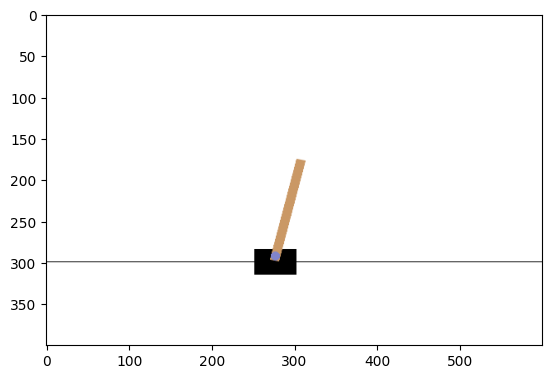

SCORE 12.0


In [4]:
agent=models.load_model("/content/drive/MyDrive/CartPole.keras")
env=gym.make("CartPole-v1",render_mode="rgb_array")
env.reset()
done=False

action = np.random.randint(0,2)
observation,reward,terminated,truncated,info=env.step(action)
done = terminated or truncated
score=0
while not done:
  current_state = tf.reshape(observation,(-1,4))
  action=np.argmax(agent.predict(current_state))
  print(action)
  observation,reward,terminated,truncated,info=env.step(action)
  frame=env.render()
  plt.imshow(frame)
  plt.show()
  done=terminated or truncated
  score+=reward
print("SCORE",score)

# **Preproccesing of our data**

In [5]:
#previous_frame = np.zeros((400,600,3),dtype=np.uint8)
previous_frame = np.zeros((210,160,3),dtype=np.uint8)
def preprocess(frame):
  global previous_frame

  #we take the maximum value for each pixel colour value over the frame being encoded and the previous frame to remove the flickering
  frame=np.maximum(previous_frame,frame)
  #previous_frame = frame
  #We extract the white channel
  y_channel = frame[:,:,1]
  #resize our frame
  y_channel=np.expand_dims(y_channel,axis=2)
  #print(y_channel.shape)
  y_channel=tf.image.resize(y_channel,[84,84])
  #plt.imshow(y_channel)
  #plt.show()
  y_channel=y_channel/255
  return y_channel


#env.close

# **Function to create our deep Q neural network**




In [6]:
def ncwh_to_nwhc(tensor):
    return tf.transpose(tensor, [0, 2, 3, 1])

def create_model(num_action):
  #We create our neural network with the architecture used in the paper provided
  model=models.Sequential()
  model.add(layers.Input(shape=(84,84,1),batch_size=4))
  #model.add(layers.Lambda(ncwh_to_nwhc, output_shape=(84, 84, 4), input_shape=(4, 84, 84)))
  model.add(layers.Conv2D(filters=32,kernel_size=8,strides=(4,4),activation='relu',kernel_initializer='he_normal'))
  model.add(layers.Conv2D(filters=64,kernel_size=4,strides=(2,2),activation='relu',kernel_initializer='he_normal'))
  model.add(layers.Conv2D(filters=64,kernel_size=3,strides=(1,1),activation='relu',kernel_initializer='he_normal'))
  model.add(layers.Flatten())
  model.add(layers.Dense(units=512,activation='relu',kernel_initializer='he_normal'))
  model.add(layers.Dense(units=num_action,activation='linear',kernel_initializer='he_normal'))

  gradient_momentum =0.95
  min_square_gradient=0.01
  # We compile our model using hyperparameters in table 1
  model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.00025,momentum=gradient_momentum,epsilon=min_square_gradient),
                loss=keras.losses.MSE)

  return model

model=create_model(6)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (4, 20, 20, 32)           2080      
                                                                 
 conv2d_1 (Conv2D)           (4, 9, 9, 64)             32832     
                                                                 
 conv2d_2 (Conv2D)           (4, 7, 7, 64)             36928     
                                                                 
 flatten (Flatten)           (4, 3136)                 0         
                                                                 
 dense (Dense)               (4, 512)                  1606144   
                                                                 
 dense_1 (Dense)             (4, 6)                    3078      
                                                                 
Total params: 1681062 (6.41 MB)
Trainable params: 168106

In [7]:
class TempList:
  def __init__(self,size):
    self.size=size
    self.d=deque(maxlen=size)

  def add(self,element):
    if(len(self.d)==self.size):
      self.d.popleft()
    self.d.append(element)

  def getElements(self):
    return list(self.d)

x=TempList(4)
for i in range(1,7):
  x.add(i)
x.getElements()

[3, 4, 5, 6]

In [8]:
states=TempList(4)
actions=TempList(4)
rewards=TempList(4)
next_states=TempList(4)
terminals=TempList(4)
class ExperienceReplay:
  def __init__(self,size):
    self.size=size
    self.memory = TempList(size)

  def add_experience(self,states,actions,rewards,next_states):
    #if our memory is full, we delete the first value in and add another to the queue
    if(states.size>=4):
      state=np.stack(states.getElements(),axis=0)
      action=actions.getElements()[-1]
      reward=rewards.getElements()[-1]
      next_state=np.stack(next_states.getElements(),axis=0)
      terminal=terminals.getElements()[-1]
      experience = (state,action,reward,next_state,terminal)
      self.memory.add(experience)
    return

  #A function to get random experiences to train our Neural network
  def get_random_experience(self,batch_size):
    return random.sample(self.memory.getElements(),batch_size)




In [9]:
class EpsilonGreedy:
  def __init__(self,agent,epsilon_init,epsilon_final,final_exploration_frame,num_action):
    self.agent=agent
    self.epsilon=epsilon_init
    self.epsilon_final=epsilon_final
    self.final_exploration_frame=final_exploration_frame
    self.epsilon_decay = (epsilon_init - epsilon_final)/(final_exploration_frame/4)
    self.num_action = num_action
  def select_action(self,state):
    p=np.random.random()
    if(self.epsilon >= p):
      #we choose a random action
      action=random.choice(list(range(num_action)))
    else:
      #We choose the action predicted by our Q function
      prediction = self.agent.predict(tf.expand_dims(state,axis=0))
      #We take the action with the maximum Q value
      action = np.argmax(prediction)
      print(action)
    self.epsilon-=self.epsilon_decay
    return action



In [10]:
num_frames=0
def repeat_action(env,action,k=4):
    global num_frames
    global previous_frame
    frame_t=preprocess(env.render())
    sum_reward=0
    for _ in range(4):
      previous_frame = env.render()
      observation,reward,terminated,truncated,info=env.step(action)
      sum_reward+=reward
      num_frames+=1
      if(terminated or truncated):
        break
    else:
      frame_t_next=preprocess(env.render())
      states.add(frame_t)
      actions.add(action)
      rewards.add(sum_reward)
      next_states.add(frame_t_next)
      terminals.add(terminated or truncated)
    return frame_t,action,sum_reward,(terminated or truncated)



In [11]:
'''def start_episode(env,num_action,noop_max):
  for _ in range (1,random.randrange(1,30)):
    action=random.choice(list(range(num_action)))
    x=env.repeat_action(env,action)
    done=x[3]'''


'def start_episode(env,num_action,noop_max):\n  for _ in range (1,random.randrange(1,30)):\n    action=random.choice(list(range(num_action)))\n    x=env.repeat_action(env,action)\n    done=x[3]'

In [12]:
def trainAgent(agent,Qtarget,minibatch,discount):
  X_train=[]
  y=[]
  #predictions=[]
  for experience in minibatch:
    state=experience[0]
    action=experience[1]
    reward=experience[2]
    next_state=experience[3]
    terminal = experience[4]
    print(state.shape)
    predicted_q_value=np.max(agent.predict(state)[:,action])
    return
    if(terminal):
      target_q_value = reward
    else:
      print(next_state.shape)
     # target_q_value = reward + discount * np.max(Qtarget.predict(next_state))
    X_train.append(state)
    #y.append(target_q_value)
    #predictions.append(predicted_q_value)
  #print(X_train[0])
  #print(y[0])
  #print(predictions[0])

# **Implementation of Deep Q-learning with experience replay**

In [13]:
#initialize the replay memory
experienceReplay=ExperienceReplay(1000)
env=gym.make("PongNoFrameskip-v4",render_mode="rgb_array")
num_action = env.action_space.n
#initialize Q function
Q=create_model(num_action)
#initalize Q target function
Q_target =create_model(num_action)
Q_target.set_weights(Q.get_weights())

In [ ]:
for episode in range(1,100):
  print("episode ",episode)
  env.reset()
  done=False
  for _ in range (1,random.randrange(1,30)):
    action=random.choice(list(range(num_action)))
    x=repeat_action(env,action)
    done=x[3]
    if(done):
      break
  s1=preprocess(env.render())
  epsilonGreedy=EpsilonGreedy(agent=Q,epsilon_init=1,epsilon_final=0.1,final_exploration_frame=1000000,num_action=num_action)
  while not done:
   #print(np.stack(states.getElements(),axis=0).shape)
   action = epsilonGreedy.select_action(np.stack(states.getElements(),axis=0))
   x=repeat_action(env,action)
   done=x[3]
   experienceReplay.add_experience(states,actions,rewards,next_states)
   if(num_frames > 50000):
    minibatch = experienceReplay.get_random_experience(batch_size=32)
    trainAgent(Q,Q_target,minibatch,0.99)
    if(num_frames/4 > 50000):
      Q_target.set_weights(Q.get_weights())




